## Generate top product recommendations for users based on their historical interactions and purchases

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV

## Import Data Files

In [2]:
data_path ='C:/Users/Nimish/Documents/ML Projects/Product Recommendations - Kaggle/Data'
file_list = os.listdir(data_path)
file_list

['category_tree.csv',
 'events.csv',
 'item_properties_part1.csv',
 'item_properties_part2.csv']

In [3]:
category_tree_df = pd.read_csv(data_path + '/' + file_list[0])
events_df = pd.read_csv(data_path + '/' + file_list[1])
item_properties1_df = pd.read_csv(data_path + '/' + file_list[2])
item_properties2_df = pd.read_csv(data_path + '/' + file_list[3])
item_properties_df = pd.concat([item_properties1_df, item_properties2_df], ignore_index=True)

## Data Pre-processing and Feature Engineering

In [4]:
# Convert timestamps from Unix to datetime format in all the 
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')
item_properties_df['timestamp'] = pd.to_datetime(item_properties_df['timestamp'], unit='ms')

In [5]:
# Replace NaN values in transactionid (signifying events other than transaction) by 0
events_df['transactionid'].fillna(0, inplace=True)

In [6]:
# Create day of week, month and hour of day features
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

events_df['day_of_week'] = events_df['timestamp'].dt.day_name()
events_df['hour'] = events_df['timestamp'].dt.hour
events_df['day_of_month'] = events_df['timestamp'].dt.day

In [7]:
# Calculate total number of events for each user and item
user_interaction_counts = events_df.groupby('visitorid')['event'].count().reset_index()
user_interaction_counts.rename(columns={'event': 'total_events_user'}, inplace=True)

item_interaction_counts = events_df.groupby('itemid')['event'].count().reset_index()
item_interaction_counts.rename(columns={'event': 'total_events_item'}, inplace=True)

# Calculate total number of unique items interacted with by each user
user_unique_items = events_df.groupby('visitorid')['itemid'].nunique().reset_index()
user_unique_items.rename(columns={'itemid': 'unique_items_interacted'}, inplace=True)

# Calculate total number of unique users interacting with each item
item_unique_users = events_df.groupby('itemid')['visitorid'].nunique().reset_index()
item_unique_users.rename(columns={'visitorid': 'unique_users_interacted'}, inplace=True)


events_df = events_df.merge(user_interaction_counts, on='visitorid', how='left')
events_df = events_df.merge(item_interaction_counts, on='itemid', how='left')
events_df = events_df.merge(user_unique_items, on='visitorid', how='left')
events_df = events_df.merge(item_unique_users, on='itemid', how='left')

print(events_df.head())

                timestamp  visitorid event  itemid  transactionid day_of_week  \
0 2015-06-02 05:02:12.117     257597  view  355908            0.0     Tuesday   
1 2015-06-02 05:50:14.164     992329  view  248676            0.0     Tuesday   
2 2015-06-02 05:13:19.827     111016  view  318965            0.0     Tuesday   
3 2015-06-02 05:12:35.914     483717  view  253185            0.0     Tuesday   
4 2015-06-02 05:02:17.106     951259  view  367447            0.0     Tuesday   

   hour  day_of_month  total_events_user  total_events_item  \
0     5             2                  2                 57   
1     5             2                 30                 34   
2     5             2                  2                 15   
3     5             2                  3                 14   
4     5             2                  1                260   

   unique_items_interacted  unique_users_interacted  
0                        2                       46  
1                       24

In [8]:
# Map events to integer values
event_mapping = {'view': 1, 'addtocart': 2, 'transaction': 3}
events_df['event_value'] = events_df['event'].map(event_mapping)

events_df = events_df.dropna(subset=['event_value'])
events_df['interaction_value'] = events_df['event'].apply(lambda x: 0.4 if x == 'view' else (0.6 if x == 'addtocart' else 0.8))

In [9]:
events_df['interaction_value'] = events_df['event'].apply(lambda x: 0.4 if x == 'view' else (0.6 if x == 'addtocart' else 0.8))

In [10]:
print(events_df.head(20))

                 timestamp  visitorid      event  itemid  transactionid  \
0  2015-06-02 05:02:12.117     257597       view  355908            0.0   
1  2015-06-02 05:50:14.164     992329       view  248676            0.0   
2  2015-06-02 05:13:19.827     111016       view  318965            0.0   
3  2015-06-02 05:12:35.914     483717       view  253185            0.0   
4  2015-06-02 05:02:17.106     951259       view  367447            0.0   
5  2015-06-02 05:48:06.234     972639       view   22556            0.0   
6  2015-06-02 05:12:03.240     810725       view  443030            0.0   
7  2015-06-02 05:34:51.897     794181       view  439202            0.0   
8  2015-06-02 04:54:59.221     824915       view  428805            0.0   
9  2015-06-02 05:00:04.592     339335       view   82389            0.0   
10 2015-06-02 05:16:02.373     176446       view   10572            0.0   
11 2015-06-02 05:08:21.252     929206       view  410676            0.0   
12 2015-06-02 05:50:29.49

## Recommendation - 1 using SVD - Surprise

In [11]:
#MSVD model training
reader = Reader(rating_scale=(0, 1))  
data = Dataset.load_from_df(events_df[['visitorid', 'itemid', 'interaction_value']], reader)

model = SVD()

cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
model.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0681  0.0686  0.0681  0.0685  0.0682  0.0683  0.0002  
MAE (testset)     0.0410  0.0411  0.0410  0.0411  0.0411  0.0411  0.0001  
Fit time          104.87  105.38  106.25  104.23  107.01  105.55  0.99    
Test time         12.89   12.25   12.91   12.72   11.77   12.51   0.44    


In [13]:
def get_top_n_recommendations(model, user_id, num_items, n=10):
    recommendations = []
    for item_id in range(1, num_items + 1):  # Assuming items are numbered from 1 to num_items
        prediction = model.predict(user_id, item_id)
        recommendations.append((item_id, prediction.est))
    
    # Sort recommendations by estimated rating
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    top_n_recommendations = recommendations[:n]
    return top_n_recommendations

In [14]:
user_id = 2
num_items = events_df['itemid'].nunique()  # Number of unique items in the dataset
print(num_items)
top_recommendations = get_top_n_recommendations(model, user_id, num_items, n=10)
print("Top Recommendations for User", user_id)
for item_id, estimated_rating in top_recommendations:
    print("Item:", item_id, "Estimated Rating:", estimated_rating)

235061
Top Recommendations for User 2
Item: 57142 Estimated Rating: 0.8917916125435521
Item: 4778 Estimated Rating: 0.8378629105250573
Item: 77387 Estimated Rating: 0.8307694760578674
Item: 158688 Estimated Rating: 0.8297766899545662
Item: 8808 Estimated Rating: 0.8282731531059786
Item: 73756 Estimated Rating: 0.8177357238776397
Item: 60145 Estimated Rating: 0.8133764863676429
Item: 117147 Estimated Rating: 0.8080545553966825
Item: 46979 Estimated Rating: 0.8043982632130826
Item: 56111 Estimated Rating: 0.8038629875047459


## Recommendation - 2 using SVD

### Feature Engineering - 2 

Following features are derived from the given data:

User Feaures: Compute User behavior based on features through number of views, addtocart and transactions, time spent on the platform.  

Product/Item Features: Compute product popularity features through number of user views, addtocart and transactions per each product-item. 

Product Family/Category Feaures: Compute Product Category popularity through category-wise views and transactions. 

User-Item Interaction Features: Frequency and time taken during interactions betwween a user and a product

Time of Day/Year features Compute time(hour) of day, day of week, and day/week of year features which 

In [15]:
# Lets merge all the files first
merged_all = events_df.merge(item_properties_df, on=['itemid', 'timestamp'], how='left').merge(category_tree_df, left_on='property', right_on='categoryid', how='left')
merged_all.head(20)

timestamp  visitorid      event  itemid  transactionid  \
0  2015-06-02 05:02:12.117     257597       view  355908            0.0   
1  2015-06-02 05:50:14.164     992329       view  248676            0.0   
2  2015-06-02 05:13:19.827     111016       view  318965            0.0   
3  2015-06-02 05:12:35.914     483717       view  253185            0.0   
4  2015-06-02 05:02:17.106     951259       view  367447            0.0   
5  2015-06-02 05:48:06.234     972639       view   22556            0.0   
6  2015-06-02 05:12:03.240     810725       view  443030            0.0   
7  2015-06-02 05:34:51.897     794181       view  439202            0.0   
8  2015-06-02 04:54:59.221     824915       view  428805            0.0   
9  2015-06-02 05:00:04.592     339335       view   82389            0.0   
10 2015-06-02 05:16:02.373     176446       view   10572            0.0   
11 2015-06-02 05:08:21.252     929206       view  410676            0.0   
12 2015-06-02 05:50:29.496      15795       view   44872            0.0   
13 2015-06-02 05:41:37.356     598426       view  156489            0.0   
14 2015-06-02 05:47:58.165     223343       view  402625            0.0   
15 2015-06-02 05:22:11.378      57036       view  334662            0.0   
16 2015-06-02 05:33:59.808    1377281       view  251467            0.0   
17 2015-06-02 05:33:56.124     287857  addtocart    5206            0.0   
18 2015-06-02 05:50:44.282    1370216       view  176721            0.0   
19 2015-06-02 04:57:58.505     158090  addtocart   10572            0.0   

   day_of_week  hour  day_of_month  total_events_user  total_events_item  \
0      Tuesday     5             2                  2                 57   
1      Tuesday     5             2                 30                 34   
2      Tuesday     5             2                  2                 15   
3      Tuesday     5             2                  3                 14   
4      Tuesday     5             2                  1                260   
5      Tuesday     5             2                  2                  3   
6      Tuesday     5             2                  2                238   
7      Tuesday     5             2                  5                 49   
8      Tuesday     4             2                  5                 17   
9      Tuesday     5             2                  2                541   
10     Tuesday     5             2                  1                354   
11     Tuesday     5             2                  3                  8   
12     Tuesday     5             2                  3                  9   
13     Tuesday     5             2                  3                 96   
14     Tuesday     5             2                  4                 45   
15     Tuesday     5             2                  5                 96   
16     Tuesday     5             2                  1                  4   
17     Tuesday     5             2                  2                 40   
18     Tuesday     5             2                  1                143   
19     Tuesday     4             2                  4                354   

    unique_items_interacted  unique_users_interacted  event_value  \
0                         2                       46            1   
1                        24                       24            1   
2                         1                       13            1   
3                         2                       10            1   
4                         1                      202            1   
5                         2                        3            1   
6                         2                      151            1   
7                         3                       39            1   
8                         5                       16            1   
9                         1                      431            1   
10                        1                      213            1   
11              

In [59]:
# Load the data (assuming you already have the merged_events DataFrame from the EDA)
df = merged_all.copy()

# Feature engineering
## User-based features
user_behavior = df.groupby('visitorid').agg({
    'itemid': 'count',
    'timestamp': ['min', 'max', 'mean']
}).reset_index()

user_behavior.columns = ['visitorid', 'item_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior['time_on_platform'] = (user_behavior['last_interaction'] - user_behavior['first_interaction'])
user_behavior['time_between_actions'] = user_behavior['time_on_platform'] / (user_behavior['item_count'] - 1)

## Item-based features
item_popularity = df.groupby('itemid').agg({
    'visitorid': 'count',
    'event': ['nunique', lambda x: sum(x == 'view'), lambda x: sum(x == 'addtocart'), lambda x: sum(x == 'transaction')]
}).reset_index()

item_popularity.columns = ['itemid', 'user_count', 'event_count', 'view_count', 'addtocart_count', 'transaction_count']
item_popularity['conversion_rate'] = item_popularity['transaction_count'] / item_popularity['addtocart_count']

## User-item interaction features
user_item_interactions = df.groupby(['visitorid', 'itemid']).agg({
    'event': 'count',
    'timestamp': ['min', 'max']
}).reset_index()

user_item_interactions.columns = ['visitorid', 'itemid', 'interaction_count', 'first_interaction', 'last_interaction']
user_item_interactions['time_between_interactions'] = user_item_interactions['last_interaction'] - user_item_interactions['first_interaction']

## Merge the features into a single DataFrame
user_features = user_behavior.drop(['first_interaction', 'last_interaction'], axis=1)
item_features = item_popularity.drop(['view_count', 'addtocart_count', 'transaction_count'], axis=1)
interaction_features = user_item_interactions.drop(['first_interaction', 'last_interaction'], axis=1)

features = interaction_features.merge(user_features, on='visitorid').merge(item_features, on='itemid')

features['time_between_interactions_seconds'] = features['time_between_interactions'].dt.total_seconds()
features['time_on_platform_seconds'] = features['time_on_platform'].dt.total_seconds()
features['time_between_actions_seconds'] = features['time_between_actions'].dt.total_seconds()
#features['avg_interaction_time'] = features['avg_interaction_time'].dt.total_seconds()
features = features.drop(['time_between_interactions','time_on_platform','time_between_actions','avg_interaction_time'], axis=1)

features.head(30)

visitorid  itemid  interaction_count  item_count  user_count  event_count  \
0           0   67045                  1           3         205            3   
1        2304   67045                  1          21         205            3   
2       15257   67045                  1           1         205            3   
3       42552   67045                  3         158         205            3   
4       45810   67045                  1           1         205            3   
5       55389   67045                  1         213         205            3   
6       59547   67045                  1           2         205            3   
7       61500   67045                  1           2         205            3   
8       65426   67045                  1           4         205            3   
9       84271   67045                  2           2         205            3   
10      88790   67045                  1           2         205            3   
11     104308   67045                  1           3         205            3   
12     105641   67045                  1           5         205            3   
13     108165   67045                  1           1         205            3   
14     108792   67045                  1           5         205            3   
15     119840   67045                  1           1         205            3   
16     138794   67045                  1           1         205            3   
17     168615   67045                  1           7         205            3   
18     178820   67045                  1           3         205            3   
19     181184   67045                  2           3         205            3   
20     200939   67045                  1           1         205            3   
21     206124   67045                  1           2         205            3   
22     208630   67045                  1           1         205            3   
23     209660   67045                  1           2         205            3   
24     230176   67045                  1           5         205            3   
25     232854   67045                  1           3         205            3   
26     236242   67045                  1           1         205            3   
27     249961   67045                  1           1         205            3   
28     250068   67045                  1           4         205            3   
29     252069   67045                  1           2         205            3   

    conversion_rate  time_between_interactions_seconds  \
0               0.5                              0.000   
1               0.5                              0.000   
2               0.5                              0.000   
3               0.5                        9717445.035   
4               0.5                              0.000   
5               0.5                              0.000   
6               0.5                              0.000   
7               0.5                              0.000   
8               0.5                              0.000   
9               0.5                            179.698   
10              0.5                              0.000   
11              0.5                              0.000   
12              0.5                              0.000   
13              0.5                              0.000   
14              0.5                              0.000   
15              0.5                              0.000   
16              0.5                              0.000   
17              0.5                              0.000   
18              0.5                              0.000   
19              0.5                          78525.317   
20              0.5                              0.000   
21              0.5                              0.000   
22              0.5                              0.000   
23              0.5                              0.000   
24              0.5                       

In [52]:
features.dtypes

visitorid                              int64
itemid                                 int64
interaction_count                      int64
item_count                             int64
property_count                         int64
category_count                         int64
user_count                             int64
event_count                            int64
conversion_rate                      float64
time_between_interactions_seconds    float64
time_on_platform_seconds             float64
time_between_actions_seconds         float64
dtype: object

In [32]:
# Replace infinity values with NaN
features = features.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with the median
features = features.fillna(features.median())

## Split the data
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42)

In [49]:
# Collaborative filtering using SVD
reader = Reader(rating_scale=(0, 1))
train_dataset = Dataset.load_from_df(train_data[['visitorid', 'itemid', 'interaction_count']], reader)
trainset = train_dataset.build_full_trainset()

# Set hyperparameters
n_factors = 50
n_epochs = 50
lr_all = 0.005
reg_all = 0.1

# Initialize SVD with specific hyperparameters
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)

# Train the model
algo.fit(trainset)

# Make predictions on the test set
testset = list(zip(test_data['visitorid'].values, test_data['itemid'].values, test_data['interaction_count'].values))
predictions = algo.test(testset)

# Calculate evaluation metrics
mae = mean_absolute_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions])
mse = mean_squared_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.28980062629103437
Mean Squared Error: 1.8519521253537823
Root Mean Squared Error: 1.360864477217986


#### Additional EDA on Features

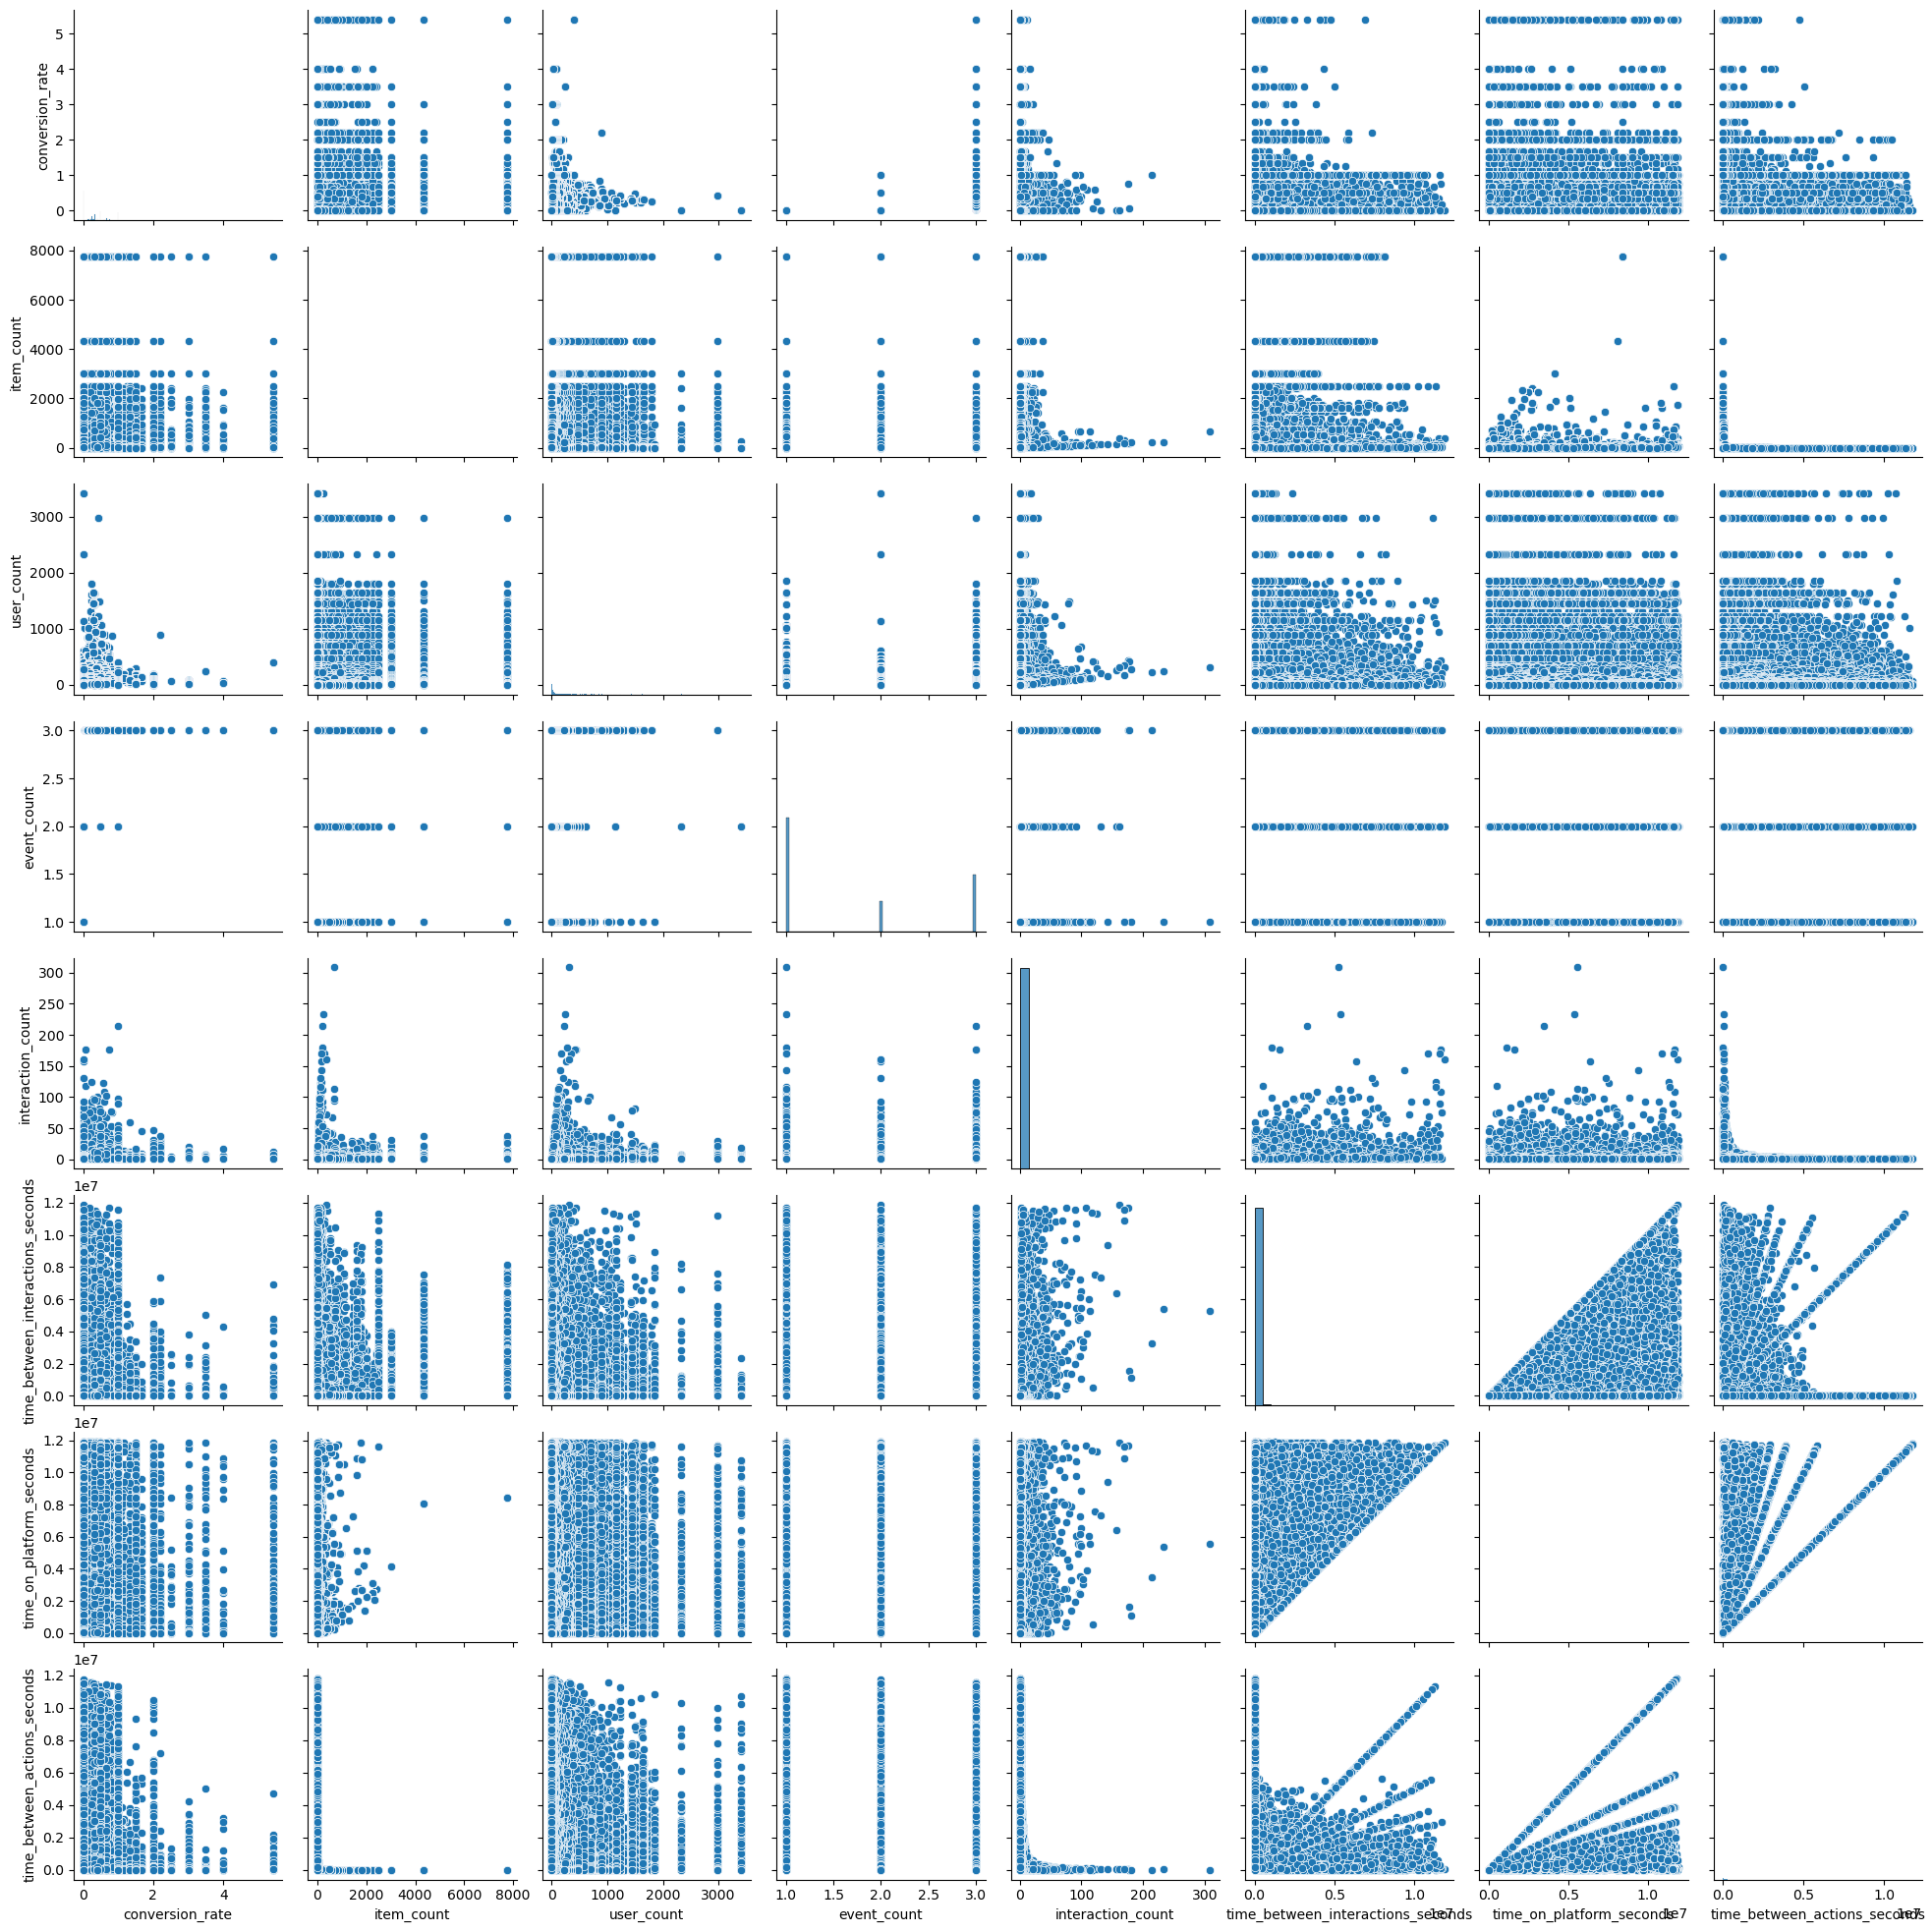

In [58]:
#Plot the data
features1 = features[['conversion_rate','item_count','user_count','event_count','interaction_count','time_between_interactions_seconds','time_on_platform_seconds','time_between_actions_seconds']]
sns.pairplot(features1)

In [55]:
from dataprep.eda import create_report
create_report(features).show_browser()

100%|############################################################################################| 3/3 [00:00<…

100%|############################################################################################| 2/2 [00:00<…

100%|############################################################################################| 2/2 [00:00<…

 75%|#####################################################################                       | 3/4 [00:00<…

  0%|                                                                                         | 0/2543 [00:00<…

C:\Users\Nimish\Anaconda3\envs\ml_env\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'time_between_...nds'
